In [2]:
path = '../../../git/LatentVelo/'
import sys
sys.path.append(path)

In [4]:
import latentvelo as ltv

In [1]:
import velvetvae as vt

# general packages
import numpy as np
import pandas as pd
import torch
from scipy.sparse import issparse

# velocity packages
import scanpy as sc
import scvelo as scv
import anndata as ann

# plotting packages
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
from IPython.display import clear_output

# color palette object
from colors import colorpalette as colpal

In [2]:
from sklearn.preprocessing import StandardScaler

import anndata
anndata.__version__

'0.8.0'

In [3]:
adata0 = vt.pp.read("../data/celltyped_adata.h5ad")
adata0 = adata0[adata0.obs.cell_annotation!='other']

adata0

View of AnnData object with n_obs × n_vars = 44713 × 24967
    obs: 'X_TC_alpha', 'total_TC_alpha', 'unspliced_TC_alpha', 'spliced_TC_alpha', 'p_e', 'p_c_TC', 'sample', 'timepoint', 'rep', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'label_rate', 'doublet_score', 'marker_based_classification', 'cell_annotation'
    layers: 'new', 'old', 'total'

In [4]:
# 1. subset cells and genes

neural_types = ['Early_Neural','Neural','pMN','p3','FP','MN','V3']

neural = adata0[[ct in neural_types for ct in adata0.obs.cell_annotation]]

# here we select only genes that are highly variable across replicates
# we exclude r4 as that is additional data that doesn't cover whole timecourse
neural_genes = vt.pp.select_genes(
    neural[neural.obs.rep!='r4'], 
    n_variable_genes=3000, 
    stratify_obs='rep')

In [5]:
import sys

sys.version

'3.10.11 (main, Apr 20 2023, 19:02:41) [GCC 11.2.0]'

In [6]:
neural = vt.pp.size_normalize(
    neural, 
    genes=neural_genes, 
    total_layer='total', 
    new_layer='new',
    unsparsify=True
)

vt.pp.neighborhood(neural)

Using ScanPy methods to calculate distances, indices, connectivities, transitions, ... done! 
KNN indices for Velvet stored in .obsm['knn_index'].
Dense similarity transition matrix for Velvet stored in .obsm['Ts'].


In [7]:
# 4. set up model
# we setup the data with scvi registration, 
# initialise the model
# and set up the model priors for rho and gamma

neural = neural.copy()

vt.ut.set_seed(0)

vt.md.Velvet.setup_anndata(neural, x_layer='total', n_layer='new', knn_layer='knn_index')

model = vt.md.Velvet(
    neural,
    n_latent = 50,
    linear_decoder = True,
    neighborhood_space="latent_space",
    biophysical_model = "full",
    gamma_mode = "learned",
    labelling_time = 2.0,
)

model.setup_model()

INFO     Generating sequential column names                                                                        


In [8]:
model.train(
    batch_size = neural.shape[0],
    max_epochs = 1000, 
    freeze_vae_after_epochs = 200,
    constrain_vf_after_epochs = 200,
    lr=0.001,
)

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 5/1000:   0%|          | 4/1000 [00:42<2:33:04,  9.22s/it, loss=3.14e+03, v_num=1]

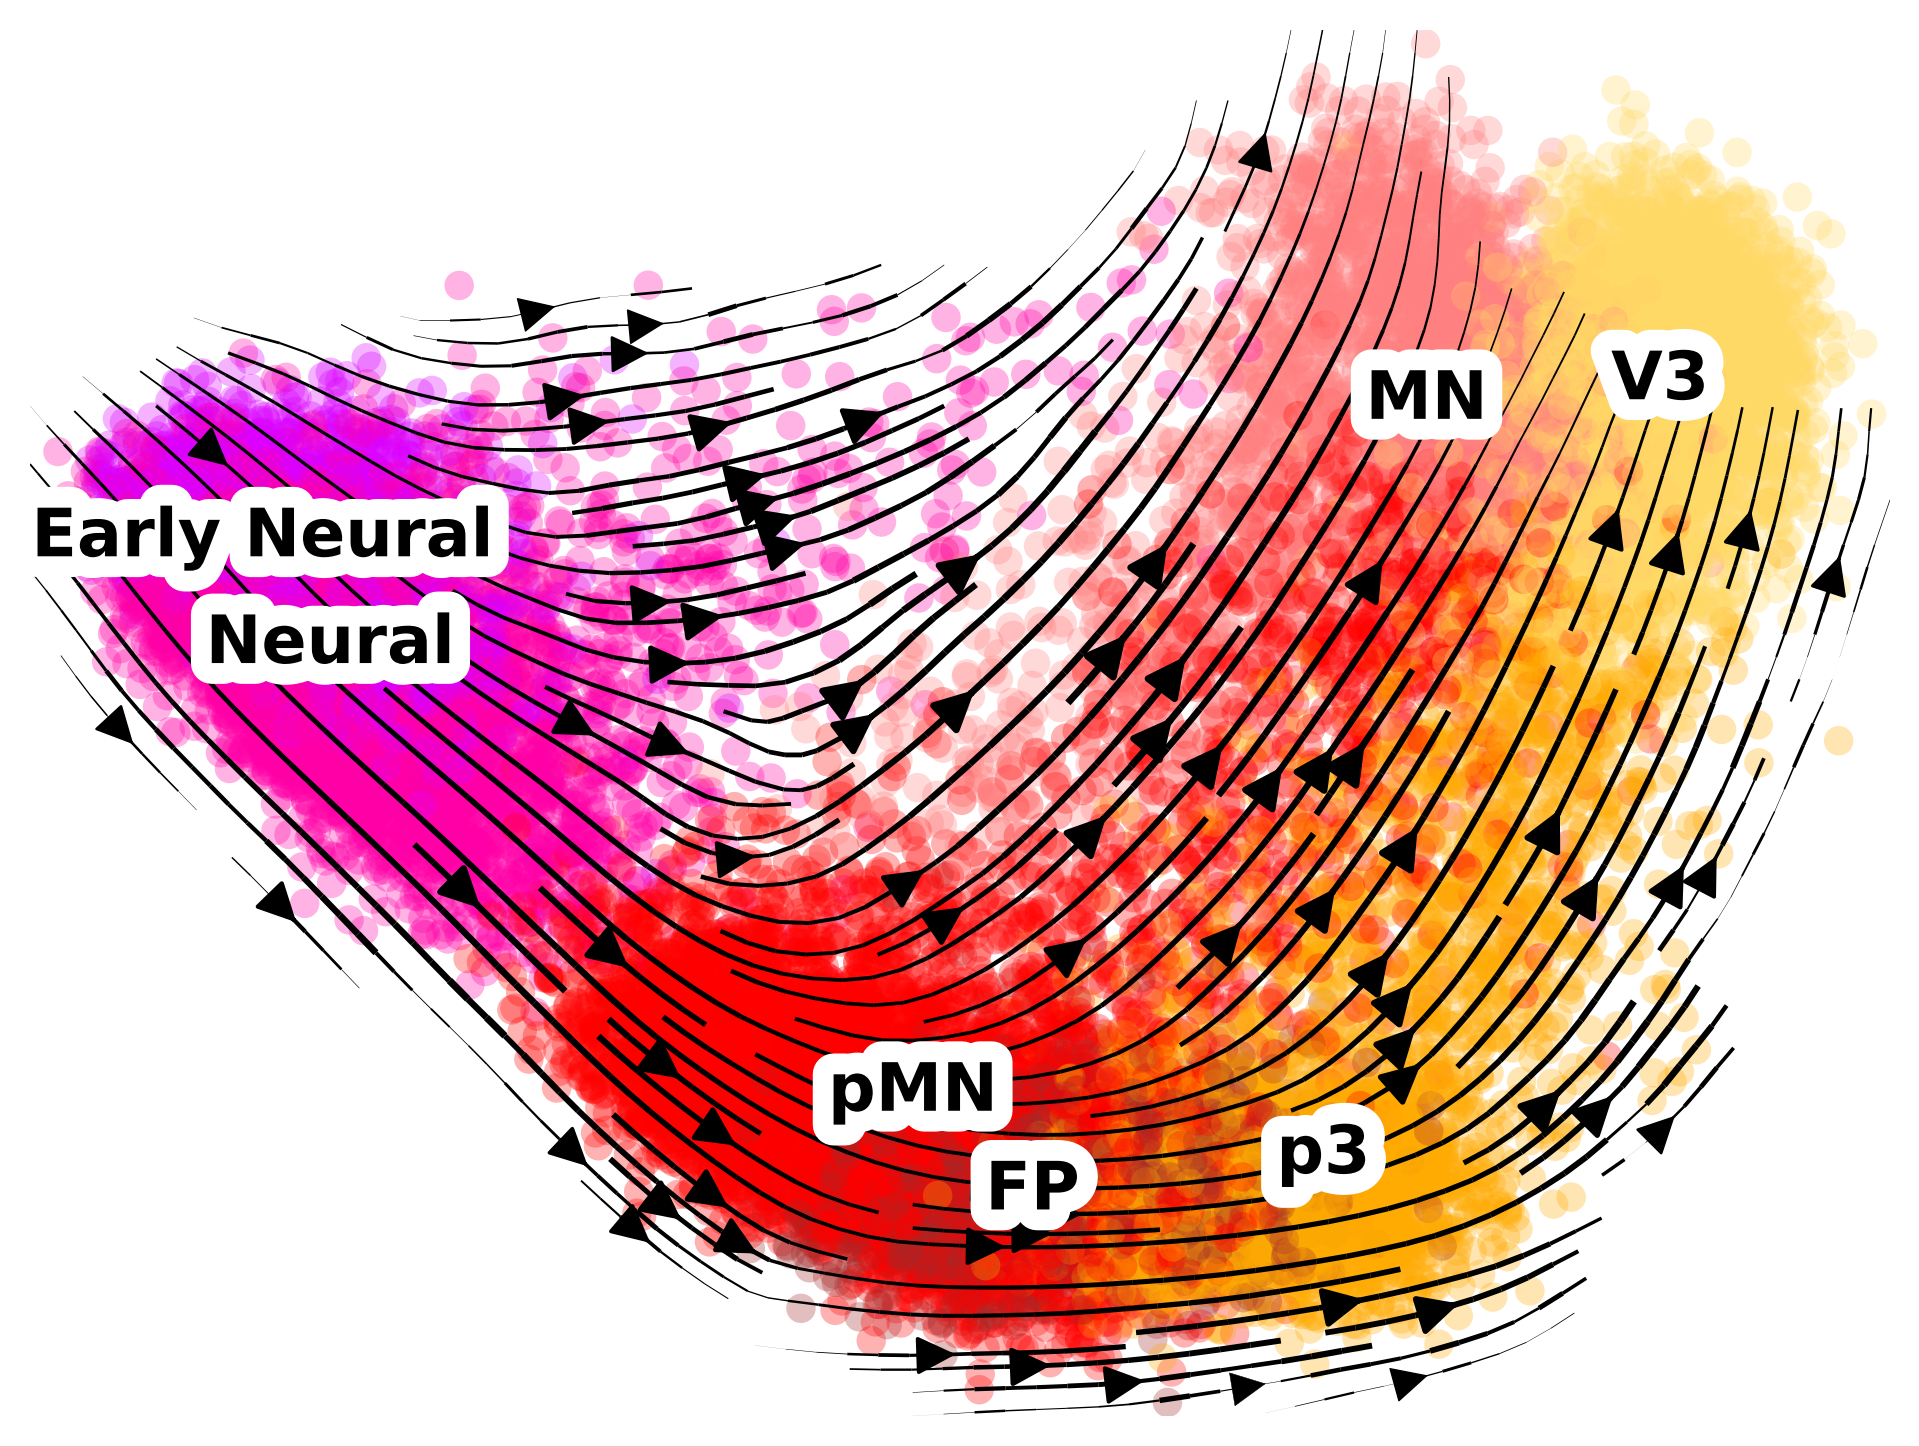

In [8]:
X = model.adata_manager.get_from_registry("X")
X = X.A if issparse(X) else X
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'

x = torch.tensor(X, device=torch_device)
b = torch.zeros(X.shape[0], device=torch_device)

z = model.module.inference(x, b)['z']
v = model.module.vf(z)

pca = PCA(n_components=10)
zs = z.detach().cpu().numpy()
zfs = (z+v).detach().cpu().numpy()
z_pca = pca.fit_transform(zs)
zf_pca = pca.transform(zfs)
v_pca = zf_pca - z_pca

copy = model.adata.copy()
copy.obsm['X_vae'] = z_pca
copy.obsm['velocity_vae'] = v_pca
copy.uns["velocity_params"] = {'embeddings':'vae'}

fig = plt.figure(figsize=(8,6), dpi=300)

ax = fig.subplots()

scv.pl.velocity_embedding_stream(
    copy, 
    basis='vae', 
    title="",
    color='cell_annotation', 
    show=False,
    ax=ax,
    palette=colpal.celltype,
    arrow_size=2,
    legend_fontoutline=10,
    size=200,
    fontsize=16, 
    legend_fontsize=16, components='1,2'
)
plt.savefig('../figures/2.0.0_neural_viz_demo.png', transparent=True)
plt.show()

does it look the same in high dimensional space?

In [9]:
scaler = StandardScaler(with_mean=True, with_std=False)
copy.layers['velocity'] = model.predict_velocity()
pca = PCA()

X = copy.layers['total']
V = copy.layers['velocity']
X = np.array(X.A if issparse(X) else X)
V = np.array(V.A if issparse(V) else V)
Y = np.clip(X + V, 0, 1000)
            
Xlogscale = scaler.fit_transform(np.log1p(X))      
Ylogscale = scaler.transform(np.log1p(Y))
Xpca = pca.fit_transform(Xlogscale)
Ypca = pca.transform(Ylogscale)

copy.obsm['X_pca'] = Xpca
copy.varm['PCs'] = pca.components_
copy.obsm['velocity_pca'] = Ypca - Xpca
copy.uns["velocity_params"] = {'embeddings':'pca'}


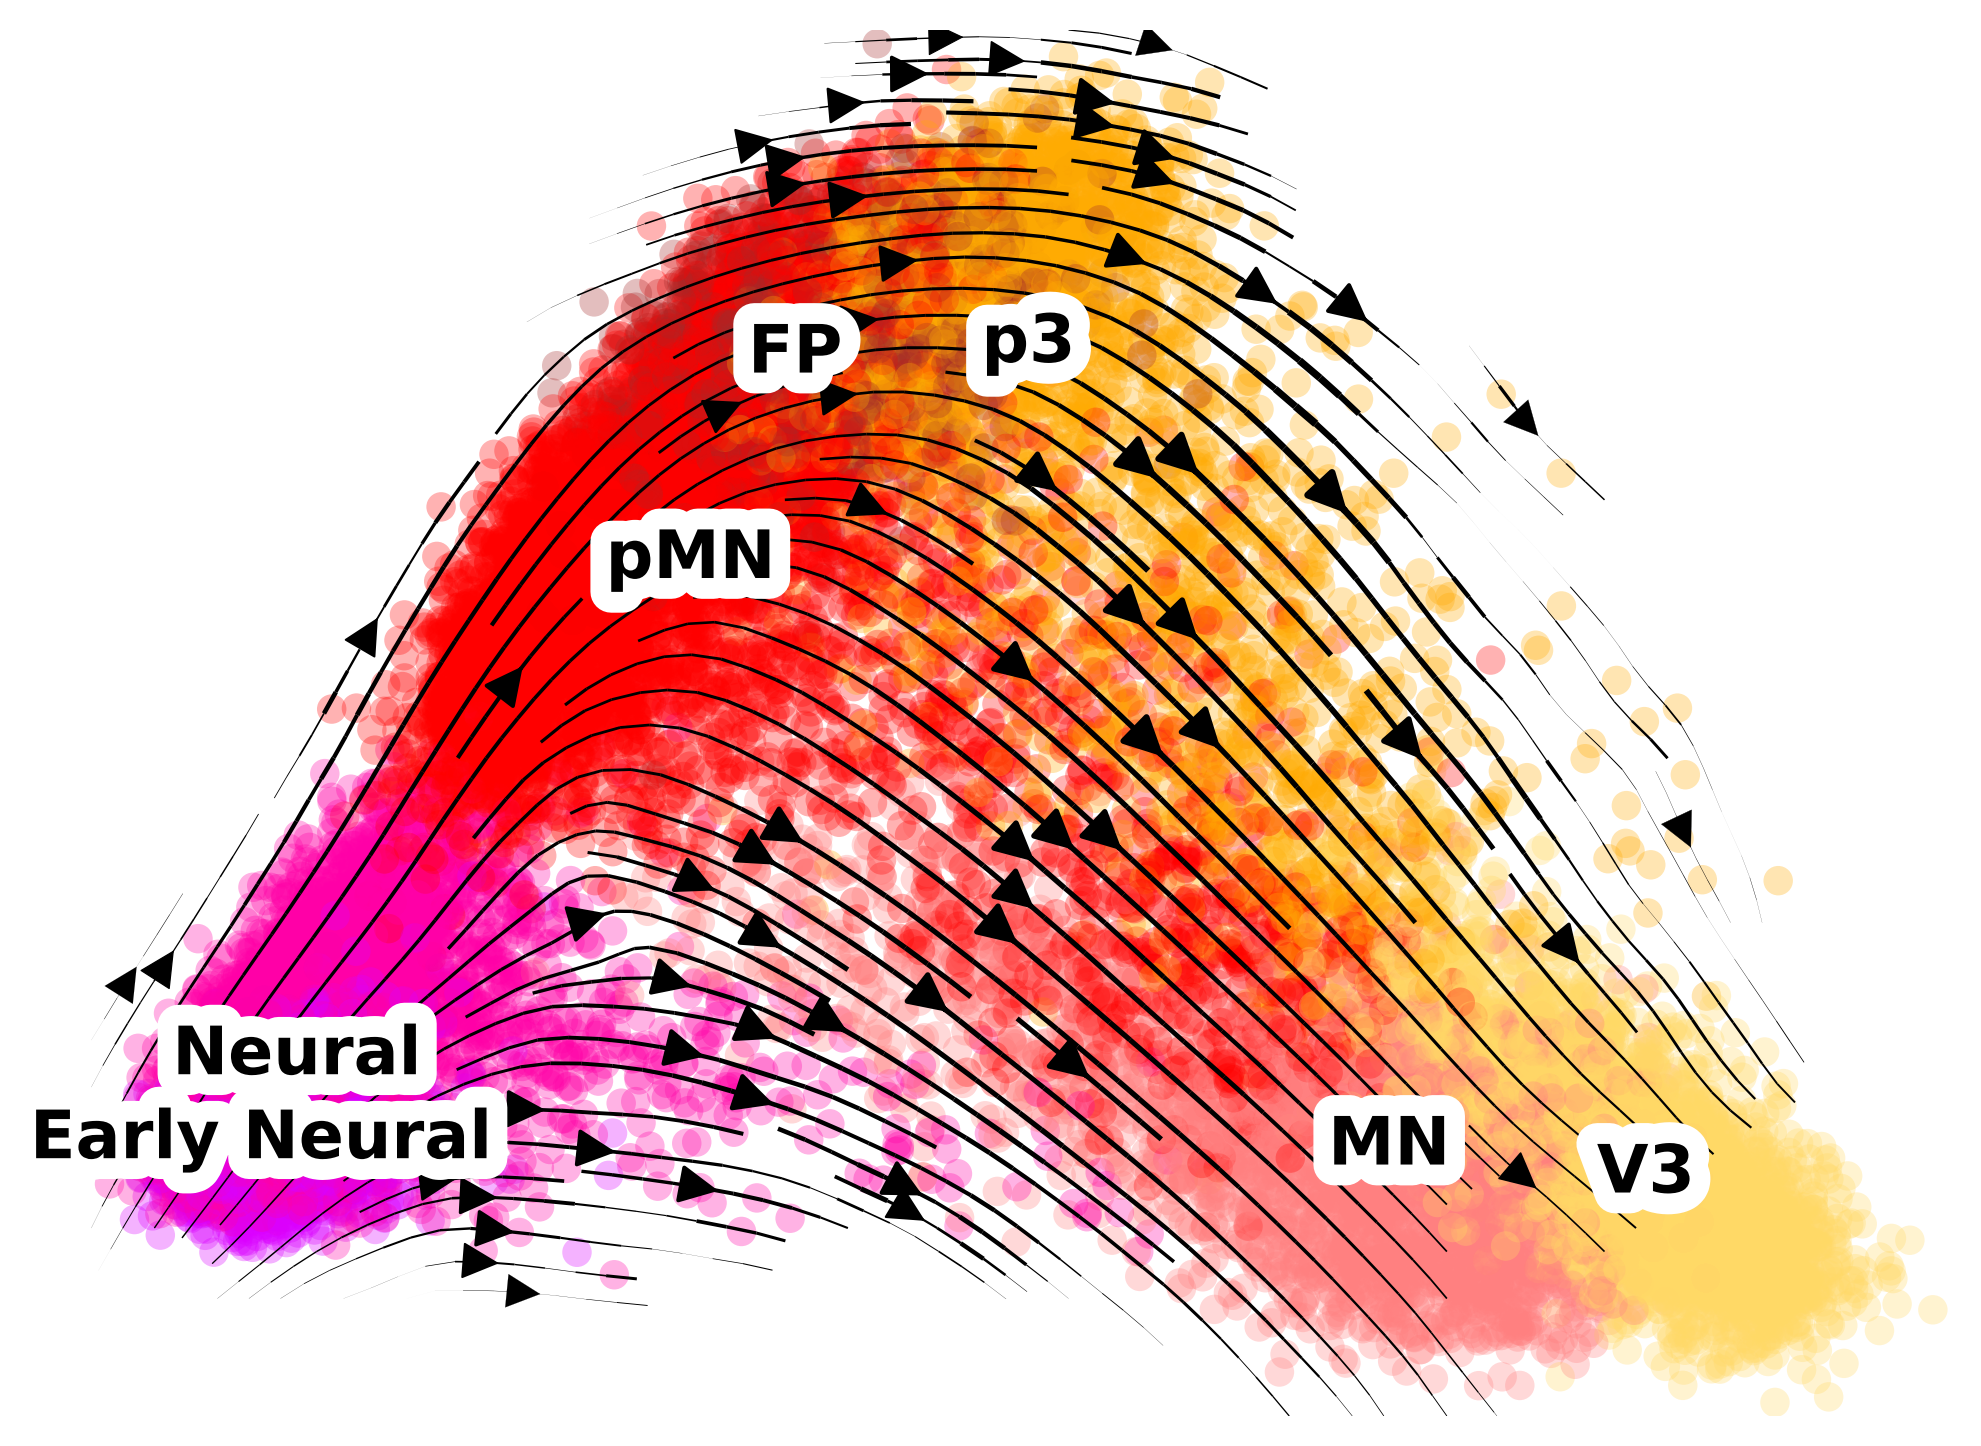

In [10]:
fig = plt.figure(figsize=(8,6), dpi=300)

ax = fig.subplots()

scv.pl.velocity_embedding_stream(
    copy, 
    basis='pca', 
    title="",
    color='cell_annotation', 
    show=False,
    ax=ax,
    palette=colpal.celltype,
    arrow_size=2,
    legend_fontoutline=10,
    size=200,
    fontsize=16, 
    legend_fontsize=16, components='1,2'
)
plt.savefig('../figures/2.0.1_neural_HDvelocity_viz.png', transparent=True)
plt.show()

# NMP

In [11]:
nt_types = ['MN', 'V3', 'p3','FP']

nmp = adata0[[ct not in nt_types for ct in adata0.obs.cell_annotation]]
nmp = nmp[[tp not in ['D3','D6','D7','D8'] for tp in nmp.obs.timepoint]]

nmp_genes = vt.pp.select_genes(
    nmp[nmp.obs.rep!='r4'], 
    n_variable_genes=2000, 
    stratify_obs='rep')

In [12]:
nmp = vt.pp.size_normalize(
    nmp, 
    genes=nmp_genes, 
    total_layer='total', 
    new_layer='new',
    unsparsify=True
)

vt.pp.neighborhood(nmp, n_neighbors=100)

Using ScanPy methods to calculate distances, indices, connectivities, transitions, ... done! 
KNN indices for Velvet stored in .obsm['knn_index'].
Dense similarity transition matrix for Velvet stored in .obsm['Ts'].


In [13]:
nmp = nmp.copy()

vt.ut.set_seed(0)

vt.md.Velvet.setup_anndata(nmp, x_layer='total', n_layer='new', knn_layer='knn_index')

model = vt.md.Velvet(
    nmp,
    n_latent = 50,
    linear_decoder = True,
    neighborhood_space="latent_space",
    biophysical_model = "full",
    gamma_mode = "learned",
    labelling_time = 2.0,
)

model.setup_model()

INFO     Generating sequential column names                                                                        


In [14]:
model.train(
    batch_size = neural.shape[0],
    max_epochs = 1000, 
    freeze_vae_after_epochs = 200,
    constrain_vf_after_epochs = 200,
    lr=0.001,
)

Multiprocessing is handled by SLURM.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 1000/1000: 100%|██████████| 1000/1000 [05:26<00:00,  3.13it/s, loss=1.89, v_num=1]  

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|██████████| 1000/1000 [05:26<00:00,  3.06it/s, loss=1.89, v_num=1]


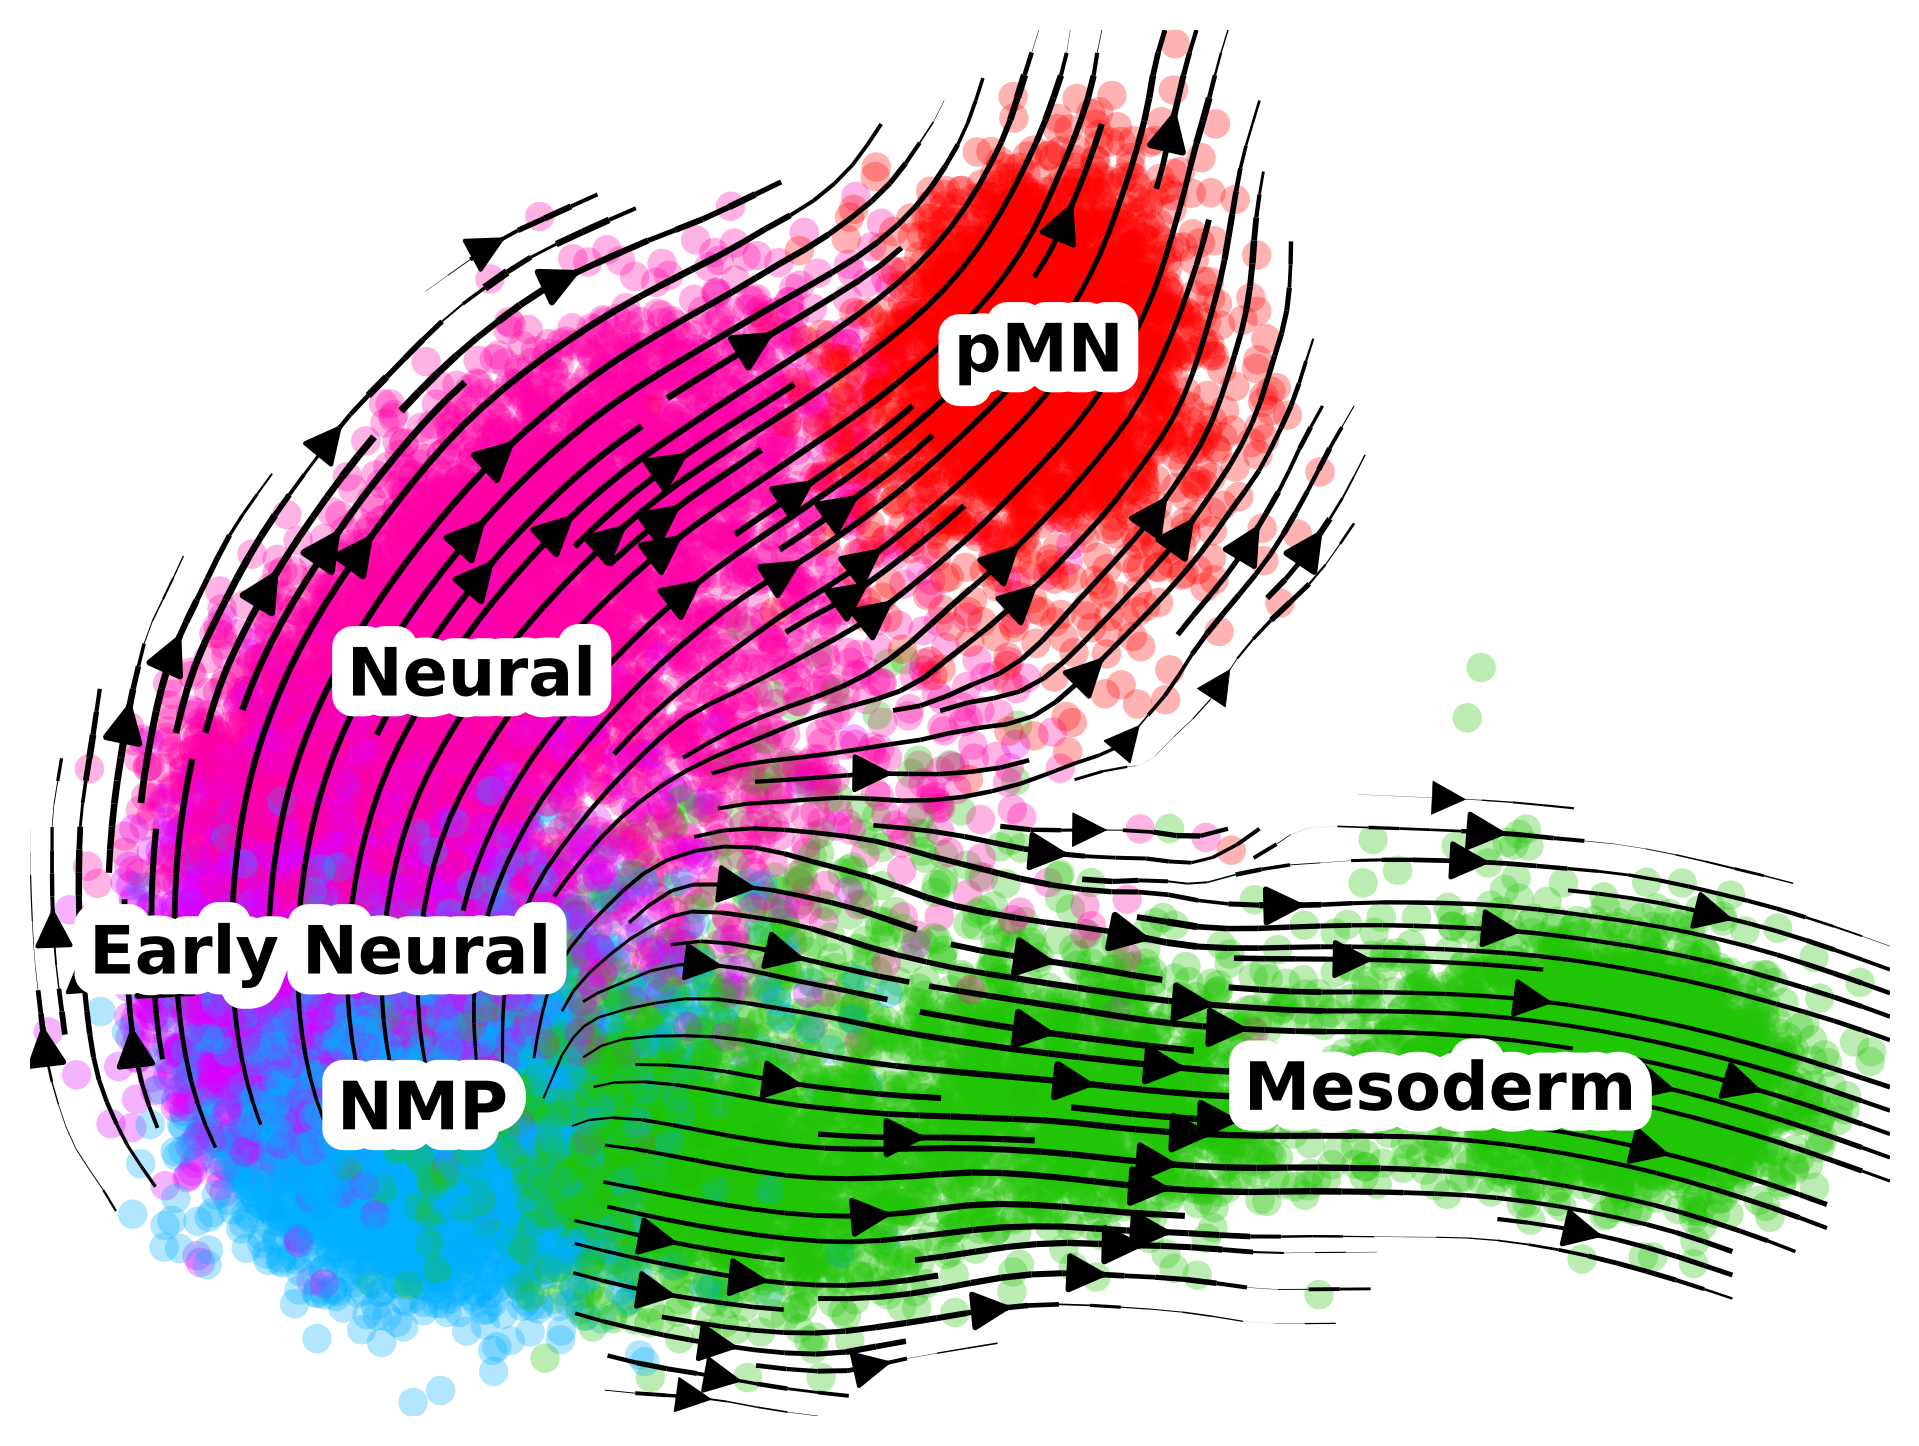

In [15]:
X = model.adata_manager.get_from_registry("X")
X = X.A if issparse(X) else X
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'

x = torch.tensor(X, device=torch_device)
b = torch.zeros(X.shape[0], device=torch_device)

z = model.module.inference(x, b)['z']
v = model.module.vf(z)

pca = PCA(n_components=10)
zs = z.detach().cpu().numpy()
zfs = (z+v).detach().cpu().numpy()
z_pca = pca.fit_transform(zs)
zf_pca = pca.transform(zfs)
v_pca = zf_pca - z_pca

copy = model.adata.copy()
copy.obsm['X_vae'] = z_pca
copy.obsm['velocity_vae'] = v_pca
copy.uns["velocity_params"] = {'embeddings':'vae'}

fig = plt.figure(figsize=(8,6), dpi=300)

ax = fig.subplots()

scv.pl.velocity_embedding_stream(
    copy, 
    basis='vae', 
    title="",
    color='cell_annotation', 
    show=False,
    ax=ax,
    palette=colpal.celltype,
    arrow_size=2,
    legend_fontoutline=10,
    size=200,
    fontsize=16, 
    legend_fontsize=16, components='1,2'
)
plt.savefig('../figures/2.0.3_nmp_viz_demo.png', transparent=True)
plt.show()

In [16]:
scaler = StandardScaler(with_mean=True, with_std=False)
copy.layers['velocity'] = model.predict_velocity()
pca = PCA()

X = copy.layers['total']
V = copy.layers['velocity']
X = np.array(X.A if issparse(X) else X)
V = np.array(V.A if issparse(V) else V)
Y = np.clip(X + V, 0, 1000)
            
Xlogscale = scaler.fit_transform(np.log1p(X))      
Ylogscale = scaler.transform(np.log1p(Y))
Xpca = pca.fit_transform(Xlogscale)
Ypca = pca.transform(Ylogscale)

copy.obsm['X_pca'] = Xpca
copy.varm['PCs'] = pca.components_
copy.obsm['velocity_pca'] = Ypca - Xpca
copy.uns["velocity_params"] = {'embeddings':'pca'}


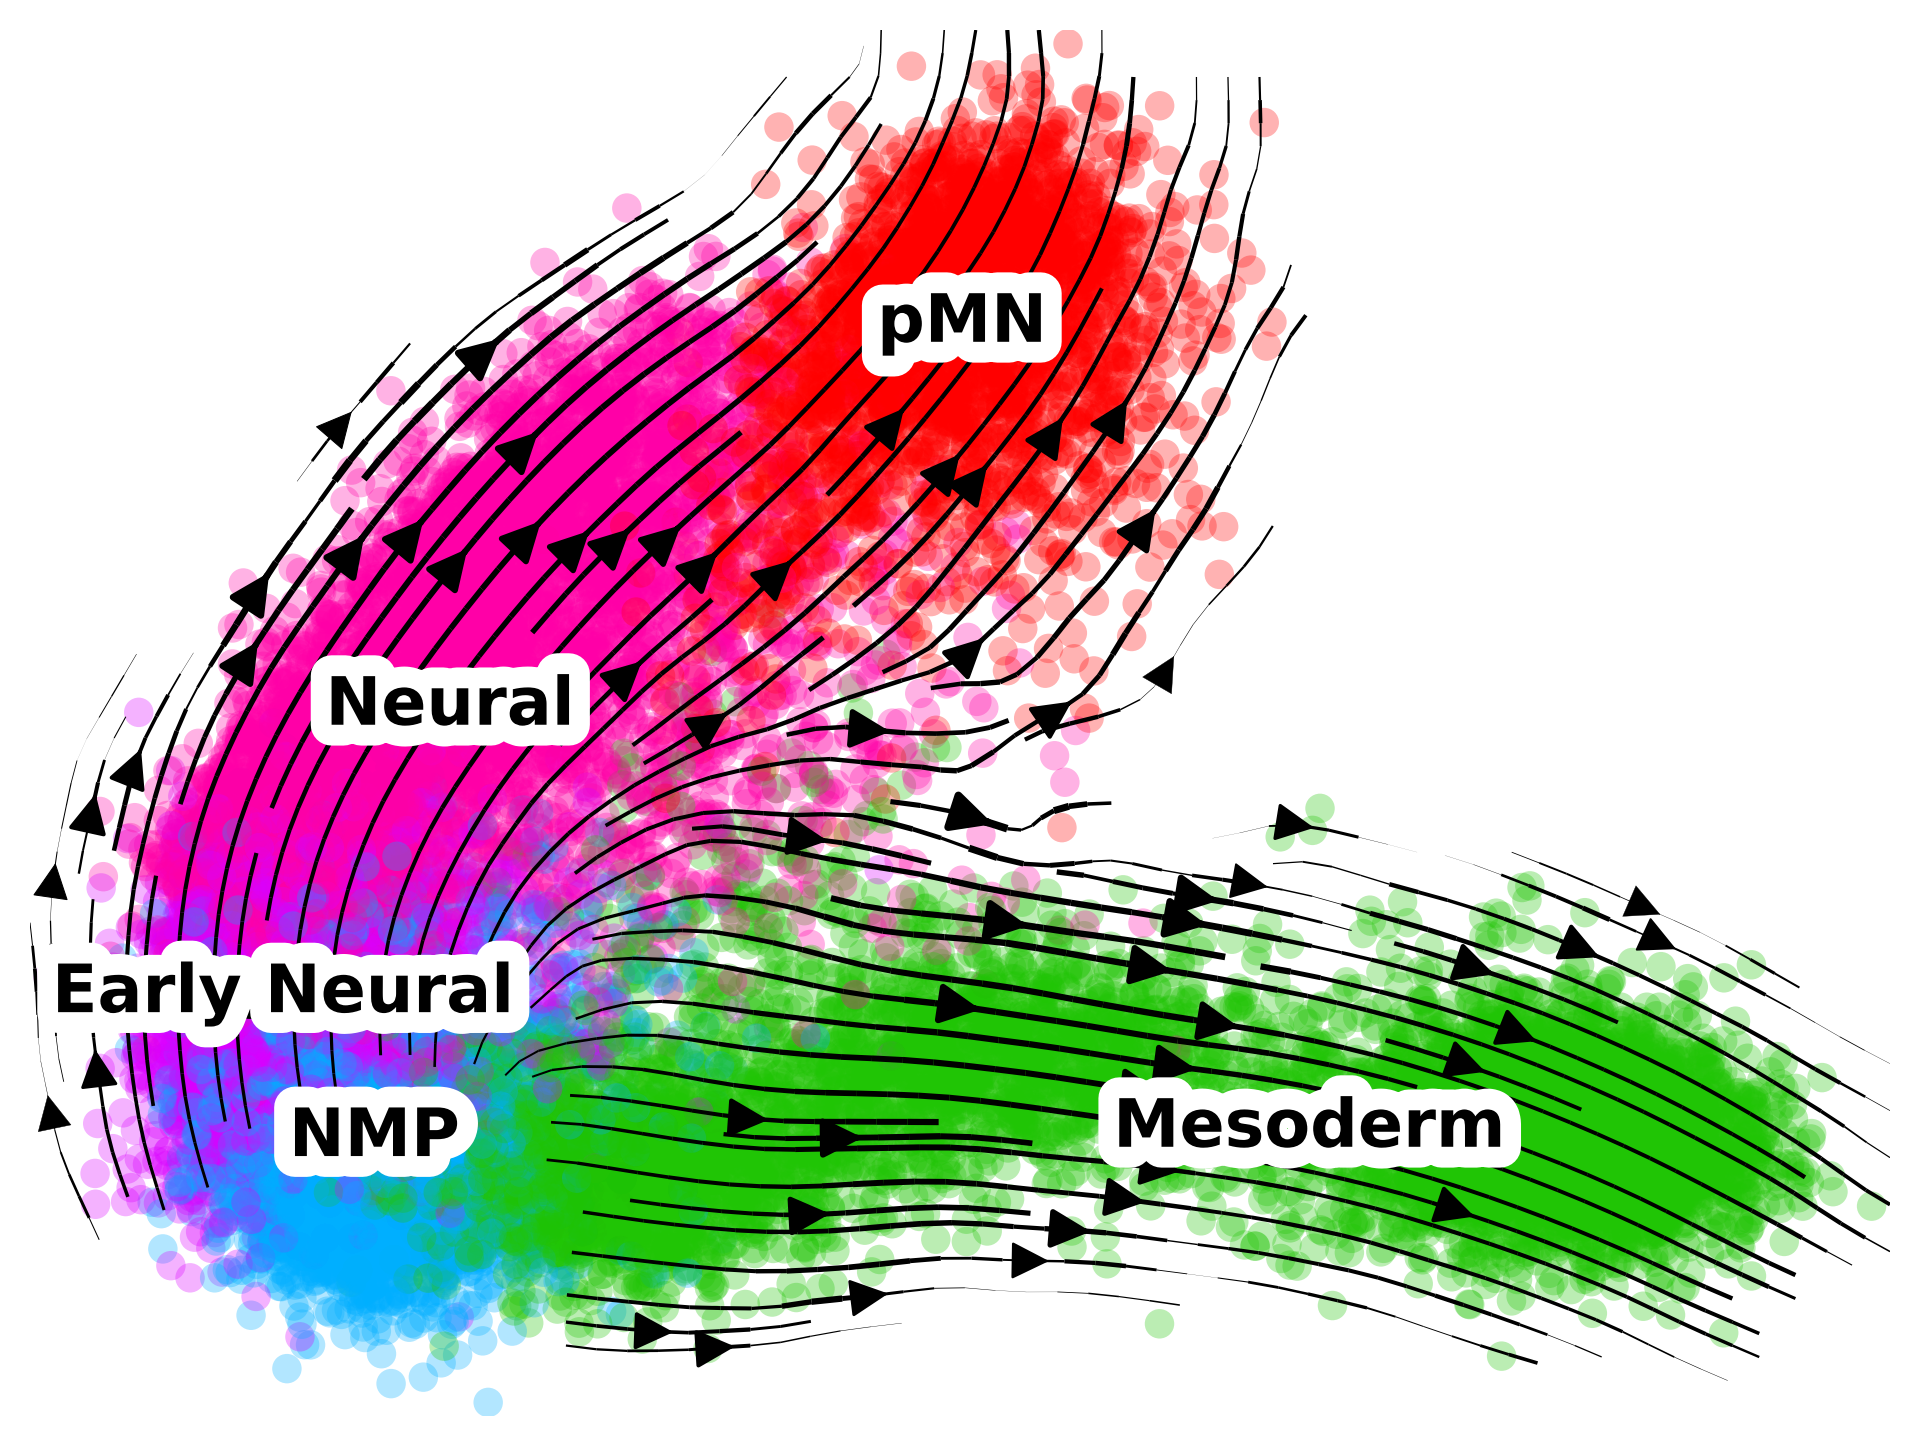

In [17]:
fig = plt.figure(figsize=(8,6), dpi=300)

ax = fig.subplots()

scv.pl.velocity_embedding_stream(
    copy, 
    basis='pca', 
    title="",
    color='cell_annotation', 
    show=False,
    ax=ax,
    palette=colpal.celltype,
    arrow_size=2,
    legend_fontoutline=10,
    size=200,
    fontsize=16, 
    legend_fontsize=16, components='1,2'
)
plt.savefig('../figures/2.0.4_nmp_HDvelocity_viz.png', transparent=True)
plt.show()